In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [9]:
# Install third-party PCA library (run once)
!pip install pca



   -------- ------------------------------- 1/5 [colourmap]
   ------------------------ --------------- 3/5 [scatterd]
   -------------------------------- ------- 4/5 [pca]
   ---------------------------------------- 5/5 [pca]



In [10]:
from pca import pca


In [4]:
# Load happiness dataset using relative path
df = pd.read_csv("../datasets/happy.csv")

# Quick check to see if import worked
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [6]:
# --- 1) Separate non-numeric columns (e.g., country/region) ---
meta_cols = df.select_dtypes(exclude=["number"]).columns.tolist()
meta = df[meta_cols].copy()  # keep for later plots/labels

# --- 2) Use only numeric columns for PCA ---
X = df.select_dtypes(include=["number"]).copy()

# Optional: drop columns that are entirely missing
X = X.dropna(axis=1, how="all")

# --- 3) Handle missing values (numeric) ---
from sklearn.impute import SimpleImputer  # new import needed for missing values

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# --- 4) Scale ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# --- 5) PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- 6) Results: scores, explained variance, loadings ---
pca_scores = pd.DataFrame(
    X_pca,
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])]
)

explained_variance = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative_explained_variance": np.cumsum(pca.explained_variance_ratio_)
})

loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Quick checks
display(explained_variance.head(10))
display(loadings.head())
pca_scores.head()


,PC,explained_variance_ratio,cumulative_explained_variance
0,PC1,0.579112,0.579112
1,PC2,0.176729,0.755841
2,PC3,0.074740,0.830581
3,PC4,0.074573,0.905154
4,PC5,0.041626,0.946780
5,PC6,0.033718,0.980498
6,PC7,0.018610,0.999108
7,PC8,0.000892,1.000000


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Overall rank,-0.441332,0.072255,-0.072974,-0.050099,0.125175,0.527062,0.114597,0.696831
Score,0.444499,-0.040704,0.060999,0.051723,-0.080806,-0.512235,-0.111864,0.716198
GDP per capita,0.405273,-0.215000,-0.290018,0.071826,-0.237465,0.217297,0.772416,0.005035
Social support,0.375583,-0.184168,0.275444,0.164592,0.819226,0.222629,0.029165,-0.022701
Healthy life expectancy,0.401246,-0.190299,-0.259899,0.103911,-0.281809,0.527307,-0.605758,0.005515


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,4.102119,1.301087,-0.702025,-1.340104,0.609440,-0.537719,-0.221029,0.157124
1,4.148422,1.551282,-0.521057,-0.431848,0.304781,-0.384257,0.171423,0.150737
2,4.192727,1.942298,-0.853305,-0.825092,0.614183,-0.424038,-0.072631,0.121699
3,3.685901,0.911713,0.661605,1.213202,-0.166698,-0.121966,-0.066084,0.155344
4,4.076408,1.368639,-0.798283,-0.686638,0.285406,-0.272128,-0.078709,0.132123


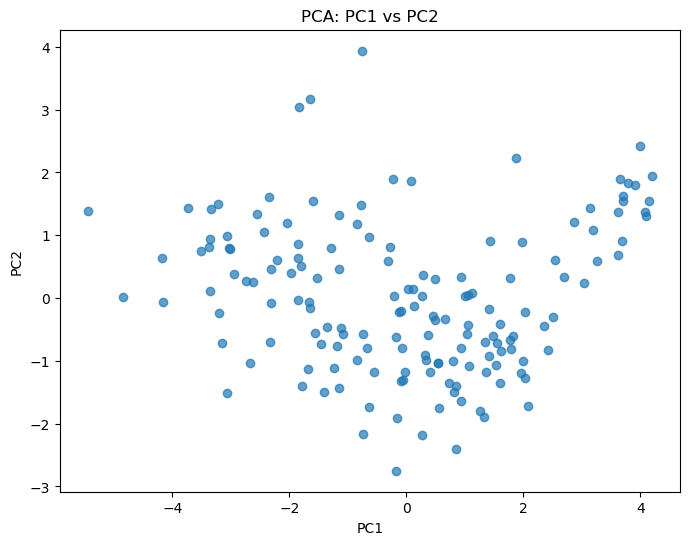

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_scores["PC1"], pca_scores["PC2"], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2")
plt.show()


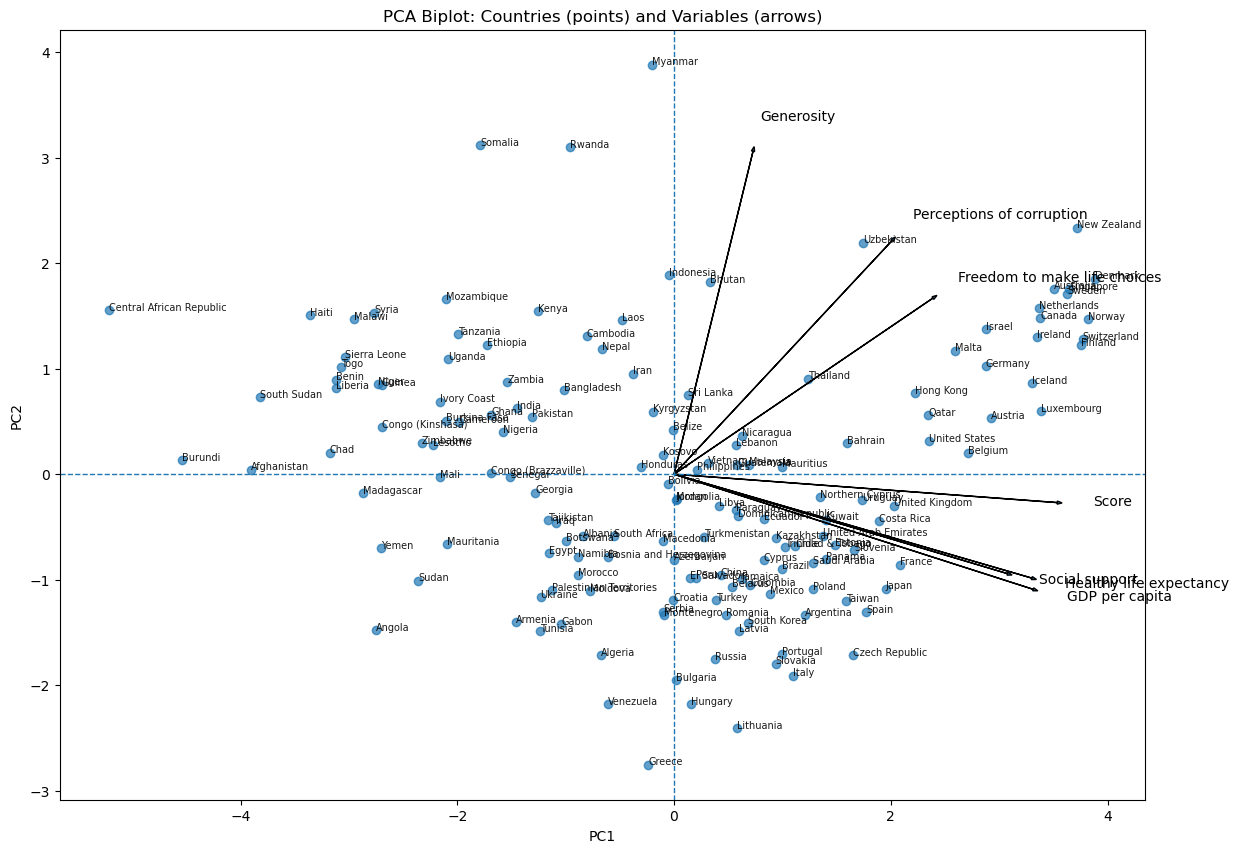

In [8]:

# 2) Define label column + feature columns
# ---------------------------
country_col = "Country or region"

# Use all numeric columns except rank as PCA features
exclude_cols = [country_col, "Overall rank"]
feature_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

# Keep country labels
countries = df[country_col].astype(str).values

# PCA input matrix
X = df[feature_cols].copy()

# ---------------------------
# 3) Impute missing values + scale
# ---------------------------
from sklearn.impute import SimpleImputer  # new import needed

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ---------------------------
# 4) PCA (2 components for PC1/PC2 plot)
# ---------------------------
pca = PCA(n_components=2)
scores = pca.fit_transform(X_scaled)  # country positions in PCA space

# Loadings (variable vectors)
# This scaling is common for biplots and makes arrows more interpretable
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# ---------------------------
# 5) Build a biplot: countries + arrows
# ---------------------------
plt.figure(figsize=(14, 10))

# Scatter of countries
plt.scatter(scores[:, 0], scores[:, 1], alpha=0.7)

# Add country labels (can get crowded, but you asked for all countries)
for i, name in enumerate(countries):
    plt.text(scores[i, 0], scores[i, 1], name, fontsize=7, alpha=0.9)

# Axes lines through origin
plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)

# Arrow scaling so vectors fit nicely into the same plot area
max_score_x = np.max(np.abs(scores[:, 0]))
max_score_y = np.max(np.abs(scores[:, 1]))
max_load_x = np.max(np.abs(loadings[:, 0]))
max_load_y = np.max(np.abs(loadings[:, 1]))

arrow_scale = 0.8 * min(max_score_x / max_load_x, max_score_y / max_load_y)

# Plot arrows + variable names
for i, var in enumerate(feature_cols):
    x_arrow = loadings[i, 0] * arrow_scale
    y_arrow = loadings[i, 1] * arrow_scale

    plt.arrow(0, 0, x_arrow, y_arrow, length_includes_head=True, head_width=0.03, linewidth=1)
    plt.text(x_arrow * 1.08, y_arrow * 1.08, var, fontsize=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot: Countries (points) and Variables (arrows)")
plt.show()


In [11]:
# Load data
df = pd.read_csv("../datasets/happy.csv")

# Target/labels (NOT used for PCA computation)
y = df["Score"]

# Features for PCA (numeric only, exclude Score)
X = df.select_dtypes(include="number").drop(columns=["Score"], errors="ignore")
labels = X.columns

# Scaling
X = StandardScaler().fit_transform(X)

# PCA
model = PCA(n_components=2)
Z = model.fit_transform(X)

# Loadings (arrows)
loadings = model.components_.T


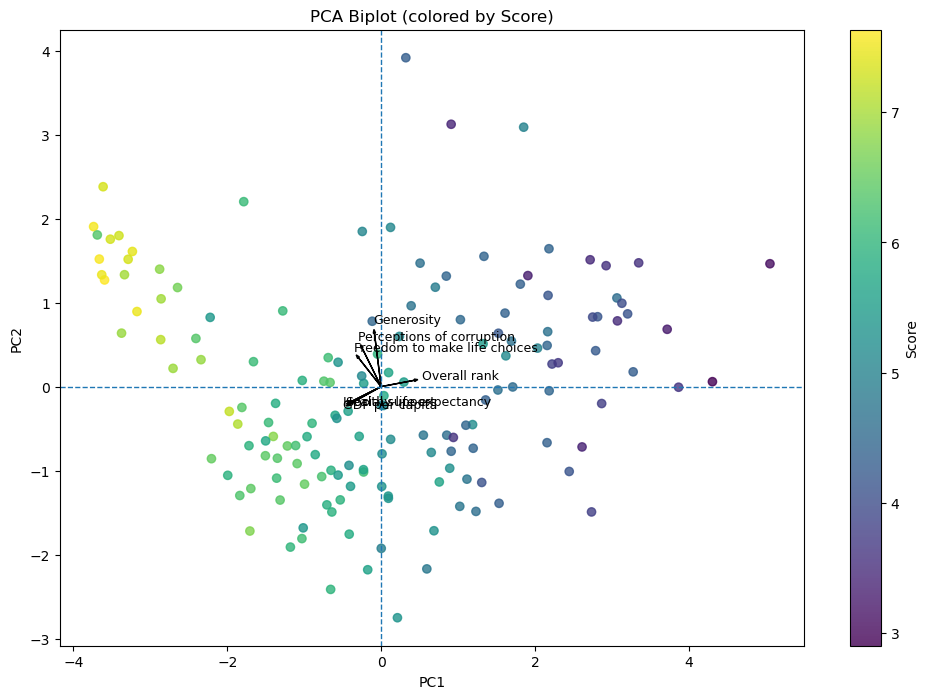

In [12]:
plt.figure(figsize=(12, 8))

# Points (countries)
plt.scatter(Z[:, 0], Z[:, 1], c=y, alpha=0.8)  # colored by Score
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot (colored by Score)")
plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)

# Arrows (variables)
for i, v in enumerate(labels):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.03, length_includes_head=True)
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, v, fontsize=9)

plt.colorbar(label="Score")
plt.show()


[18-12-2025 15:42:54] [pca.pca] [INFO] PCA reduction performed to capture at least 95.0% explained variance using 7 columns of the input data.
[18-12-2025 15:42:54] [pca.pca] [INFO] Fit using PCA.
[18-12-2025 15:42:54] [pca.pca] [INFO] Compute loadings and PCs.
[18-12-2025 15:42:54] [pca.pca] [INFO] Compute explained variance.
[18-12-2025 15:42:54] [pca.pca] [INFO] The top 5 principal component(s) explains >= 95.00% of the explained variance.
[18-12-2025 15:42:54] [pca.pca] [INFO] The PCA reduction is performed on 7 variables (columns) of the input dataframe.
[18-12-2025 15:42:54] [pca.pca] [INFO] Fit using PCA.
[18-12-2025 15:42:54] [pca.pca] [INFO] Compute loadings and PCs.
[18-12-2025 15:42:54] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[18-12-2025 15:42:54] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[18-12-2025 15:42:54] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]
[18

(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'The top 5 Principal Component(s) explains [95.33%] of the variance.'}, xlabel='PC1 (53.4% expl.var)', ylabel='PC2 (20.1% expl.var)'>)

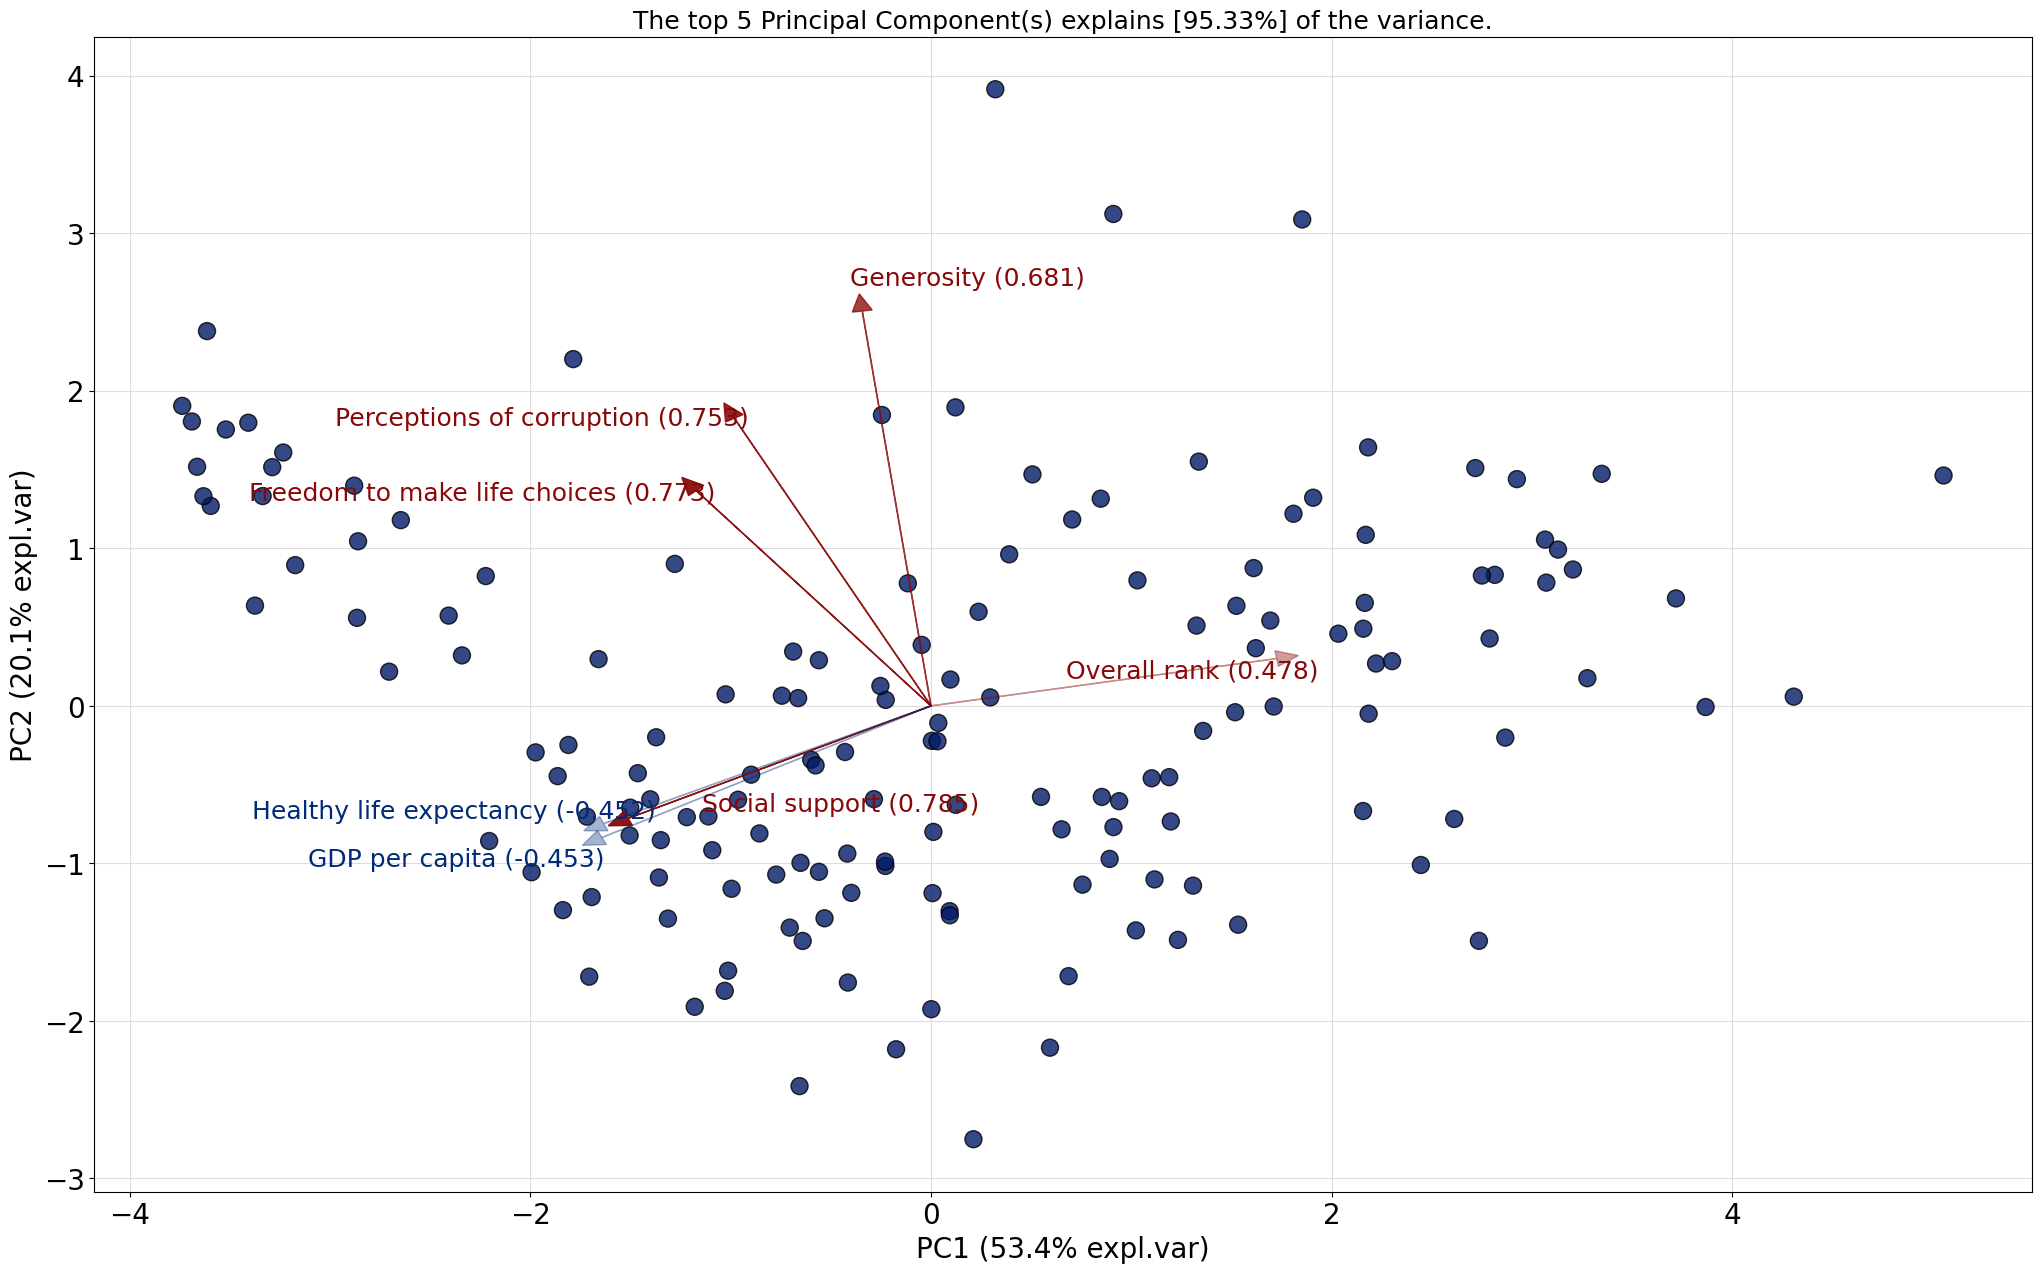

In [13]:
# Copy data
df = pd.read_csv("../datasets/happy.csv").copy()

# Row labels (countries)
row_labels = df["Country or region"]

# Target variable (NOT used in PCA, just kept separately)
y = df.pop("Score")

# PCA features (numeric only)
X = df.select_dtypes(include="number")
labels = X.columns

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initializing model
model = pca()

# Fit transform with labels
results = model.fit_transform(
    X,
    col_labels=labels,
    row_labels=row_labels
)

# Biplot
model.biplot()
